# Linear Programming for classification problems

## Notebook environment

The next cells are raw cell for documentation purposes, they can be changed to code cells to install all needed libraries and restore the environment in which this notebook was created.

## Problem

Let's assume we have a linear programming model that solve:

$
\begin{aligned}
\text{Maximise:} & \quad z = 3x + 5y \\
\text{Subject to:} & \quad x + 2y \le 10 \\
& \quad x \ge 0, y \ge 0
\end{aligned}
$

Usually we'll find this kind of models to solve regression or continuos optimisation problems. Those kind of models cannot be solved in a way that we can think of them for classification purposes and which let us create, for exmaple a confusion matrix, to compare its performance against real data classes.

On the other hand, if what we want to do is classify the points in a plane as belonging to a class A or B, we can see the problem as one in which we look for a straight line $ ax + by + c = $ that divides the plane and separates it into two regions, where each corresponds to a category of data. Let's create a dataset for this purpose.

In [1]:
import numpy as np

# Training data points (x1, x2), and labels (+1 or -1)
X = np.array([
    [2, 3],
    [3, 3],
    [3, 5],
    [5, 2],
    [1, 1],
    [2, 1],
    [1, 0],
    [0, 2]
])
y = np.array([1, 1, 1, 1, -1, -1, -1, -1])

We wish to find $w = [a,b]$ y $c$ such as:

$$
y_i(ax_i + bx_i + c) \ge 1 \quad \forall i
$$

This is a simplified form of a linear hard SVM, and can be solved as a linear programming problem.

In [2]:
from scipy.optimize import linprog

# Number of features
n = X.shape[1]

# Variables: a, b, c (hyperplane parameters)
# Objective: To minimise 0 (we are only interested in feasibility here))
c_obj = np.zeros(n + 1)  # [a, b, c]

# Restricciones: y_i * (a x_i + b x_i + c) >= 1
# Se reescribe como: -y_i * (a x_i + b x_i + c) <= -1
A_ub = -y[:, None] * np.hstack((X, np.ones((len(X), 1))))
b_ub = -np.ones(len(X))

# Resolver
res = linprog(c=c_obj, A_ub=A_ub, b_ub=b_ub, method='highs')

w = res.x[:2]
c = res.x[2]

print("Parámetros encontrados:")
print(f"a = {w[0]:.3f}, b = {w[1]:.3f}, c = {c:.3f}")


TypeError: 'NoneType' object is not subscriptable

We found a problem here. Let's see what is the content of `res`.

In [3]:
res

       message: The problem is infeasible. (HiGHS Status 8: model_status is Infeasible; primal_status is None)
       success: False
        status: 2
           fun: None
             x: None
           nit: 0
         lower:  residual: None
                marginals: None
         upper:  residual: None
                marginals: None
         eqlin:  residual: None
                marginals: None
       ineqlin:  residual: None
                marginals: None

So, the problem is that the `linprog` method is declaring the problem as "infeasible". Let's first plot out point in a graph.

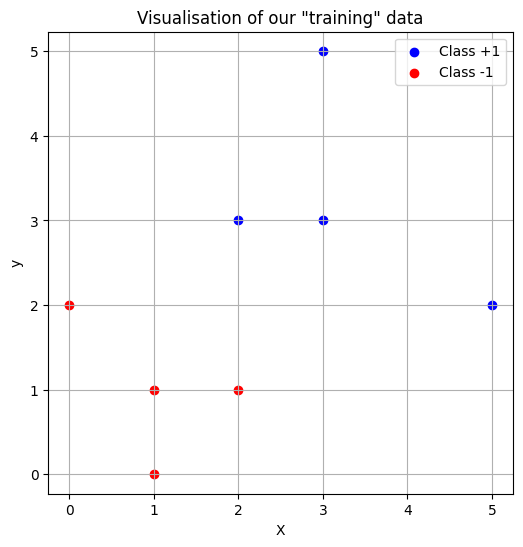

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Datos de entrenamiento
X = np.array([
    [2, 3],
    [3, 3],
    [3, 5],
    [5, 2],
    [1, 1],
    [2, 1],
    [1, 0],
    [0, 2]
])
y = np.array([1, 1, 1, 1, -1, -1, -1, -1])

# Graficar los puntos
plt.figure(figsize=(6, 6))
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Class +1')
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='red', label='Class -1')
plt.title('Visualisation of our "training" data')
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


Ideally we could draw a straight line defined by:

In [5]:
# x values between -1 and 6
x_line = np.arange(-1, 7)
y_line = -x_line + 4  # y = -x + 4

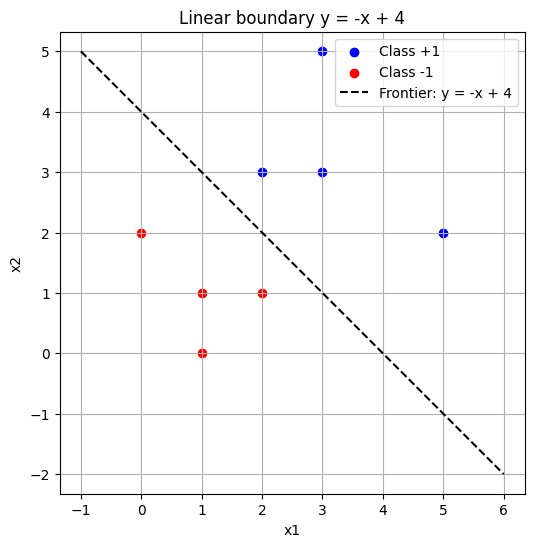

In [6]:
# Graph with line
plt.figure(figsize=(6, 6))

# Original dataset
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Class +1')
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='red', label='Class -1')

# Tentative line
plt.plot(x_line, y_line, 'k--', label='Frontier: y = -x + 4')

# Points on the line
#plt.plot(x_int_vals, y_int_vals_new, 'go', label='Puntos enteros sobre y = -x + 4')

plt.title("Linear boundary y = -x + 4")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

Which can suggest that the problem has a solution and it is possible to separate both data sets. However, when we use linear programming to separate with:

$$
y_i (w^Tx_i+c) \ge 1
$$

What we demand is not only separation, but that each point is at a minimum distance of the hyperplane such that this inequality is fulfilled. That is to say that it is not enough that any point is "on the right side", they must be separated by at least one unit margin strip. For every point $x_i$ of class $+1$, it is required:

$$
w^T x_i +  x \ge 1
$$

And for one of class $–1$:

$$
w^T x_i +  x \le -1
$$

This generates a margin strip between $–1$ and $+1$, from which no point can be inside. In our case, we have a point in each class in the border of this marging strip. To deal with this restriction, we reformulate our model with slack variables, which allows points within the margin or even poorly classified, in exchange for minimising the total errors.

$$
y_i(w^T x_i + c) \ge 1 - \xi, \quad \xi_i \ge 0
$$

So, we add the slack variable $\xi$ to allow some points to be inside our margin strip, or even be misclassified:

$$
\begin{aligned}
\text{Maximise:} & \quad \sum_{i=1}^{n} \xi_i \\
\text{Subject to:} & \quad y_i(w^T x_i + c) \ge 1 - \xi, \quad \forall i, \xi_i \ge 0 
\end{aligned}
$$

where:

$
\begin{aligned}
\quad \quad w \in \mathbb{R}, & \text{ coefficient on the linear boundary} \\
\quad \quad c \in \mathbb{R}, & \text{ independent variable} \\
\quad \quad \xi \ge 0,        & \text{ slack variables for each point} 
\end{aligned}
$

So, if there are $n$ data, the problem has $2 + 1+ n = n + 3$ variables.

In [7]:
n_samples, n_features = X.shape
n_vars = n_features + 1 + n_samples  # w1, w2, c, and one ξ for each sample

# Objective: minimise sum of ξ_i
c_obj = np.zeros(n_vars)
c_obj[n_features + 1:] = 1  # penalize only the ξ_i

# Constraints: y_i * (w^T x_i + c) >= 1 - ξ_i
# And becomes: -y_i * (w^T x_i + c) - ξ_i <= -1

A_ub = np.zeros((n_samples, n_vars))
b_ub = -np.ones(n_samples)

for i in range(n_samples):
    A_ub[i, :n_features] = -y[i] * X[i]     # w1, w2
    A_ub[i, n_features] = -y[i]             # c
    A_ub[i, n_features + 1 + i] = -1        # ξ_i

# Limits: w and c free, but ξ_i ≥ 0
bounds = [(None, None)] * (n_features + 1) + [(0, None)] * n_samples

# Solving with linprog
res_hol = linprog(c=c_obj, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')

# Extracting results
w_sol = res_hol.x[:n_features]
c_sol = res_hol.x[n_features]
xi_vals = res_hol.x[n_features+1:]

w_sol, c_sol, xi_vals.tolist()

(array([0.5, 1. ]), np.float64(-3.0), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

Although the "hard" model failed with margin $ \ge 1$, when solving the slack model, the optimizer found a feasible solution without real errors. This suggests that there is a valid border, but the previous one was too tight in requiring margin $ \ge 1$ strictly.

The learned linear boundary is:

$$
0.5 𝑥 + 1.0y − 3 = 0 \quad ⇒ \quad y = − 0.5𝑥_1 + 3
$$

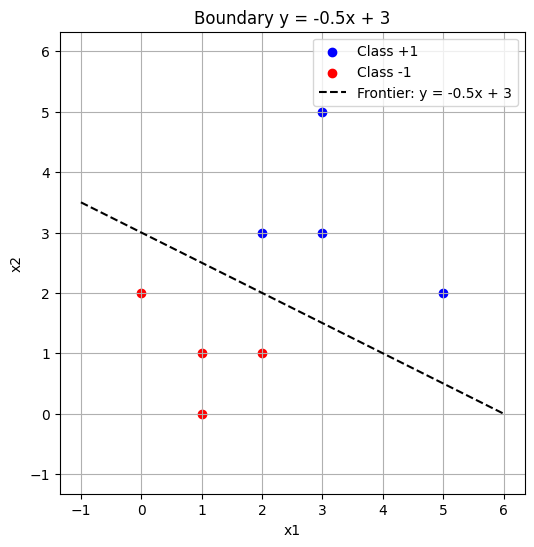

In [10]:
# New line
x_line = np.arange(-1, 7)
y_line = -0.5 * x_line + 3

# Graph with line
plt.figure(figsize=(6, 6))

# Original dataset
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Class +1')
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='red', label='Class -1')

# Drawing
plt.plot(x_line, y_line, 'k--', label='Frontier: y = -0.5x + 3')

plt.title("Boundary y = -0.5x + 3")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()